In [1]:
from __future__ import print_function

import configparser
import sys, os
import spotipy
import spotipy.oauth2 as oauth2
import json

import vamp
import librosa
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
%matplotlib inline

from scipy import stats

from src.melosynth import melosynth

config = configparser.ConfigParser()
config.read('../keys.cfg')
client_id = config.get('SPOTIFY', 'CLIENT_ID')
client_secret = config.get('SPOTIFY', 'CLIENT_SECRET')

auth = oauth2.SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)

token = auth.get_access_token()
sp = spotipy.Spotify(auth=token)

uri = 'spotify:user:spotifycharts:playlist:37i9dQZEVXbLRQDuF5jeBp'
username = uri.split(':')[2]
playlist_id = uri.split(':')[4]

results = sp.user_playlist(username, playlist_id)
songs = results['tracks']['items']

In [2]:
def extractMelody(data_file):

    # - http://www.justinsalamon.com/news/melody-extraction-in-python-with-melodia
    
    # Load 30s sample and extract melody
    mp3_f = urllib.request.urlretrieve(preview_url)[0]
    audio, sr = librosa.load(mp3_f, sr=44100, mono=True)
    
    '''
    Melodia Parameters
        minfqr:  minimum frequency in Hertz (default 55.0)
        maxfqr:  maximum frequency in Hertz (default 1760.0)
        voicing: voicing tolerance. Greater values will result in more pitch contours included 
                in the final melody. Smaller values will result in less pitch contours 
                included in the final melody (default 0.2).
        minpeaksalience: (in Sonic Visualiser "Monophonic Noise Filter") is a hack to avoid 
                silence turning into junk contours when analyzing monophonic recordings (e.g. 
                solo voice with no accompaniment). Generally you want to leave this untouched 
                (default 0.0).
    '''
    params = {"minfqr": 55.0, "maxfqr": 1760.0, "voicing": 0.2, "minpeaksalience": 0.0}

    data = vamp.collect(audio, sr, "mtg-melodia:melodia", parameters=params)
    hop, melody = data['vector']
    
    # the first timestamp is always 8 * hop
    hop = 128/44100.0
    first_timestamp = 8 * hop #= 8 * hop = 0.023219954648526078
    # Generate corresponding timestamp array
    timestamps = first_timestamp + np.arange(len(melody)) * hop
    
    '''
    Plot Extracted Melody
        Melodia returns unvoiced (=no melody) sections as negative values. A clearer option is to 
        get rid of the negative values before plotting. Finally, you might want to plot the pitch 
        sequence in cents rather than in Hz. This especially makes sense if you are comparing two 
        or more pitch sequences to each other (e.g. comparing an estimate against a reference).
    '''

    melody_cents = 1200*np.log2(melody/55.0)
    melody_cents[melody<=0] = None
    plt.figure(figsize=(18,6))
    plt.plot(timestamps, melody_cents)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (cents relative to 55 Hz)')
    plt.show()
    
    return(timestamps, melody)

In [3]:
def createMelody(_times, _freqs, _track_uri):
    
    melosynth(_times, _freqs, outputid=_track_uri, fs=16000, nHarmonics=1, square=False, useneg=False)

https://p.scdn.co/mp3-preview/e554d0ab4dac8fedd148ad4c45d6e8cd37c0125c?cid=f6c97a562e044a11bb475c79783b6f81


/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log2


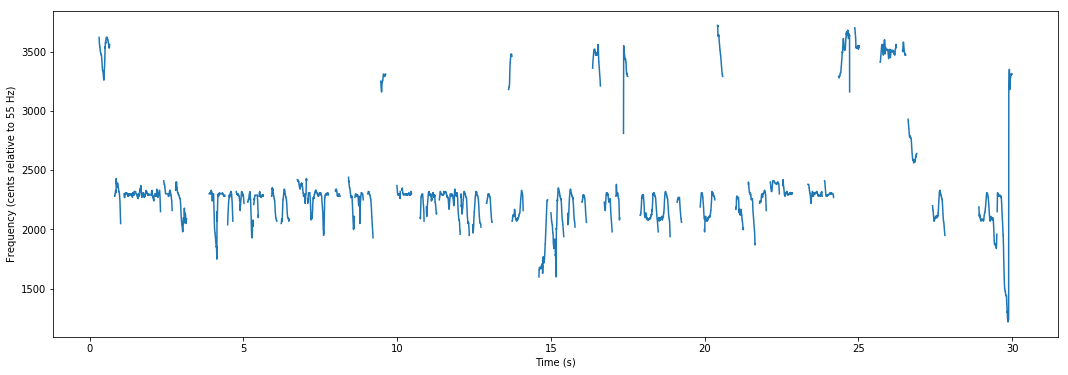

In [4]:
for song in songs[:1]:
    
    # Get name, uri, preview_url
    track = song['track']
    track_uri = track['uri'].split(':')[2]
    #analysis = sp.audio_analysis(track_uri)
    preview_url = track['preview_url']
    print(preview_url)
    
    # Extract Melody and create Melody wav
    timestamps, melody = extractMelody(preview_url)
    

In [5]:
createMelody(timestamps, melody, track_uri)

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...


[0. 0. 0. ... 0. 0. 0.]


error: required argument is not an integer

In [3]:
# print(json.dumps(songs, indent=2))

#print(json.dumps(analysis, indent=2))
    #with open('song.json', 'w') as outfile:
     #   json.dump(analysis, outfile, indent=2)

In [46]:
timestamps


array([2.32199546e-02, 2.61224490e-02, 2.90249433e-02, ...,
       3.00408163e+01, 3.00437188e+01, 3.00466213e+01])

# Final Python File